## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 預防錯誤： OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

# 三層隱藏層，一個輸出層(softmax)
def build_mlp(input_shape, output_units=10, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.Dense(units=512, activation="relu", name="hidden_layer_0")(input_layer)
    x = BatchNormalization()(x)
    x = keras.layers.Dense(units=256, activation="relu", name="hidden_layer_1")(x)
    x = BatchNormalization()(x)
    x = keras.layers.Dense(units=128, activation="relu", name="hidden_layer_2")(x)
    x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def focal_loss_fixed(y_true, y_pred):
    """Focal loss for multi-classification
    FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
    """
    gamma = 2.0
    alpha = 4.0
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)

def cross_entropy(y_true, y_pred):
    return K.categorical_crossentropy(y_pred,y_true) 

def combined_loss(ce_weight: float = 0.7):
    """Define the customized loss."""
    fl_weight = 1.0 - ce_weight
    def do_loss(y_true, y_pred):
        return tf.add(tf.multiply(fl_weight , focal_loss_fixed(y_true, y_pred)) , 
                      tf.multiply(ce_weight , cross_entropy(y_true, y_pred))) 
    
    return do_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [16]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s-%s" % (i, ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128) 

Epoch 49/50
50000/50000 [==============================] - 12s 240us/step - loss: 0.7168 - acc: 0.9717 - val_loss: 9.8594 - val_acc: 0.4663
Epoch 50/50
50000/50000 [==============================] - 12s 243us/step - loss: 0.6617 - acc: 0.9742 - val_loss: 9.8259 - val_acc: 0.4725
Numbers of exp: 1, ce_weight: 0.30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_20 (B

Epoch 47/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.8245 - acc: 0.9666 - val_loss: 9.5443 - val_acc: 0.4859
Epoch 48/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.7760 - acc: 0.9683 - val_loss: 9.3642 - val_acc: 0.4876
Epoch 49/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.7311 - acc: 0.9709 - val_loss: 9.6446 - val_acc: 0.4870
Epoch 50/50
50000/50000 [==============================] - 12s 235us/step - loss: 0.6823 - acc: 0.9732 - val_loss: 9.6373 - val_acc: 0.4833
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_nor

Epoch 45/50
50000/50000 [==============================] - 12s 247us/step - loss: 0.9210 - acc: 0.9618 - val_loss: 9.5316 - val_acc: 0.4809
Epoch 46/50
50000/50000 [==============================] - 12s 245us/step - loss: 0.8901 - acc: 0.9639 - val_loss: 9.2921 - val_acc: 0.4895
Epoch 47/50
50000/50000 [==============================] - 12s 249us/step - loss: 0.8363 - acc: 0.9654 - val_loss: 9.8405 - val_acc: 0.4712
Epoch 48/50
50000/50000 [==============================] - 12s 249us/step - loss: 0.7892 - acc: 0.9679 - val_loss: 9.4290 - val_acc: 0.4847
Epoch 49/50
50000/50000 [==============================] - 12s 247us/step - loss: 0.7578 - acc: 0.9704 - val_loss: 9.8272 - val_acc: 0.4786
Epoch 50/50
50000/50000 [==============================] - 12s 248us/step - loss: 0.7292 - acc: 0.9701 - val_loss: 9.6807 - val_acc: 0.4707
Numbers of exp: 3, ce_weight: 0.70
_________________________________________________________________
Layer (type)                 Output Shape              Para

Epoch 43/50
50000/50000 [==============================] - 13s 250us/step - loss: 0.9798 - acc: 0.9592 - val_loss: 9.2701 - val_acc: 0.4890
Epoch 44/50
50000/50000 [==============================] - 13s 250us/step - loss: 0.9410 - acc: 0.9613 - val_loss: 9.5482 - val_acc: 0.4721
Epoch 45/50
50000/50000 [==============================] - 13s 252us/step - loss: 0.8728 - acc: 0.9649 - val_loss: 9.4971 - val_acc: 0.4743
Epoch 46/50
50000/50000 [==============================] - 12s 249us/step - loss: 0.8451 - acc: 0.9653 - val_loss: 9.2803 - val_acc: 0.4850
Epoch 47/50
50000/50000 [==============================] - 12s 249us/step - loss: 0.7628 - acc: 0.9701 - val_loss: 9.4466 - val_acc: 0.4832
Epoch 48/50
50000/50000 [==============================] - 13s 252us/step - loss: 0.7228 - acc: 0.9717 - val_loss: 9.6261 - val_acc: 0.4749
Epoch 49/50
50000/50000 [==============================] - 13s 251us/step - loss: 0.6706 - acc: 0.9733 - val_loss: 9.5824 - val_acc: 0.4882
Epoch 50/50
50000/50

Epoch 41/50
50000/50000 [==============================] - 12s 249us/step - loss: 1.1205 - acc: 0.9524 - val_loss: 9.2450 - val_acc: 0.4859
Epoch 42/50
50000/50000 [==============================] - 13s 251us/step - loss: 1.0778 - acc: 0.9546 - val_loss: 9.5021 - val_acc: 0.4812
Epoch 43/50
50000/50000 [==============================] - 12s 249us/step - loss: 1.0316 - acc: 0.9563 - val_loss: 9.5018 - val_acc: 0.4709
Epoch 44/50
50000/50000 [==============================] - 13s 250us/step - loss: 0.9751 - acc: 0.9588 - val_loss: 9.4619 - val_acc: 0.4799
Epoch 45/50
50000/50000 [==============================] - 13s 251us/step - loss: 0.9083 - acc: 0.9626 - val_loss: 9.5746 - val_acc: 0.4768
Epoch 46/50
50000/50000 [==============================] - 13s 251us/step - loss: 0.8431 - acc: 0.9656 - val_loss: 9.2833 - val_acc: 0.4900
Epoch 47/50
50000/50000 [==============================] - 13s 250us/step - loss: 0.7956 - acc: 0.9681 - val_loss: 9.5062 - val_acc: 0.4833
Epoch 48/50
50000/50

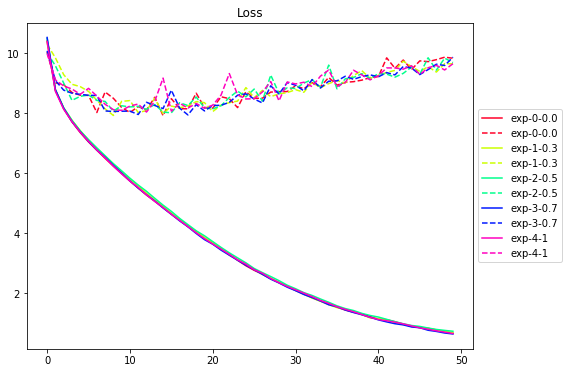

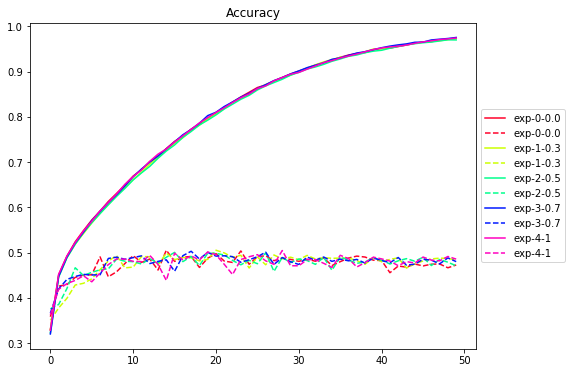

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()